Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Request stock prices in realtime for four tech companies (Apple, Google, Microsoft, Amazon) using historical data from Yahoo Finance.

In [ ]:
yf.pdr_override()

comp_dw = ['AAPL']
comp_nm = ["APPLE"]
comp_ls = [AAPL]

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in comp_dw:
    globals()[stock] = yf.download(stock, start, end)


[*********************100%%**********************]  1 of 1 completed


Plot Apple's closing and sales volume

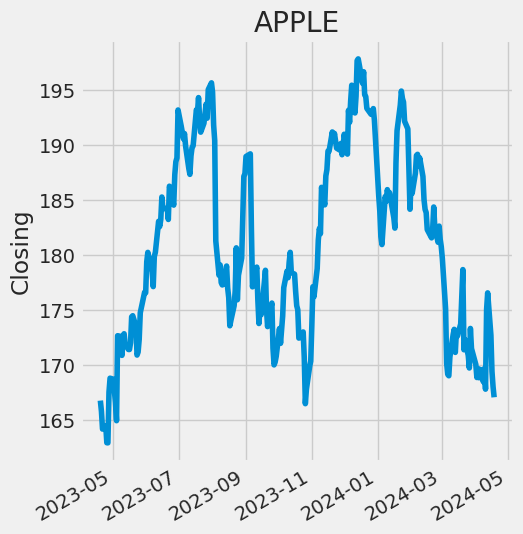

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(comp_ls, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Closing')
    plt.xlabel(None)
    plt.title(f"{comp_nm[i - 1]}")

plt.tight_layout()

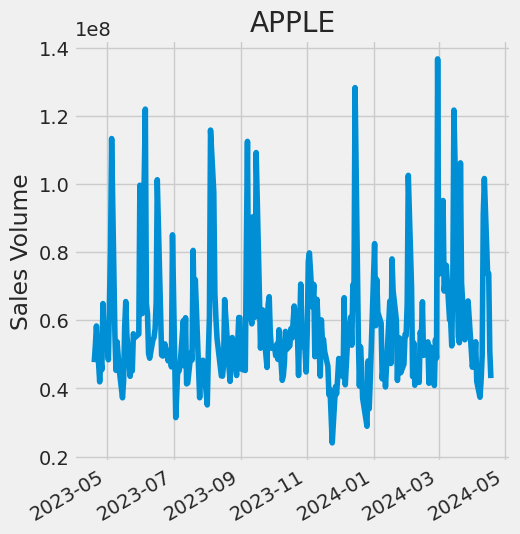

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(comp_ls, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Sales Volume')
    plt.xlabel(None)
    plt.title(f"{comp_nm[i - 1]}")

plt.tight_layout()

Get the data from yahoo within specified dates.

In [ ]:
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())

[*********************100%%**********************]  1 of 1 completed


Call the scaler and scale data

In [ ]:
data = df.filter(['Close'])
dataset = data.values

training_data_len = int(np.ceil( len(dataset) * .95 ))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.84399649],
       [0.83650309],
       [0.83129026]])

Create the training data and reshape it

In [ ]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387,
       0.02077746, 0.02165789, 0.02164044, 0.02410915, 0.02375813,
       0.02440779, 0.02557523, 0.0262249 , 0.02809631, 0.02945961,
       0.02985329, 0.02999098, 0.02765997, 0.02709757, 0.02718096,
       0.02937236, 0.02998905, 0.03131358, 0.03443581, 0.03860139,
       0.0378218 , 0.03782373, 0.04083544, 0.04177794, 0.04110694,
       0.04049413, 0.03985611, 0.04197573, 0.0434302 , 0.04403914])]
[0.042534249860459186]

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.0

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error',metrics = ['accuracy'])

model_history=model.fit(x_train,y_train, batch_size=1, epochs=1)

2879/2879 [==============================] - 152s 51ms/step - loss: 0.0013 - accuracy: 3.4734e-04


In [ ]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

5/5 [==============================] - 0s 36ms/step


<ipython-input-72-68bb27c821ab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Pred'] = predictions


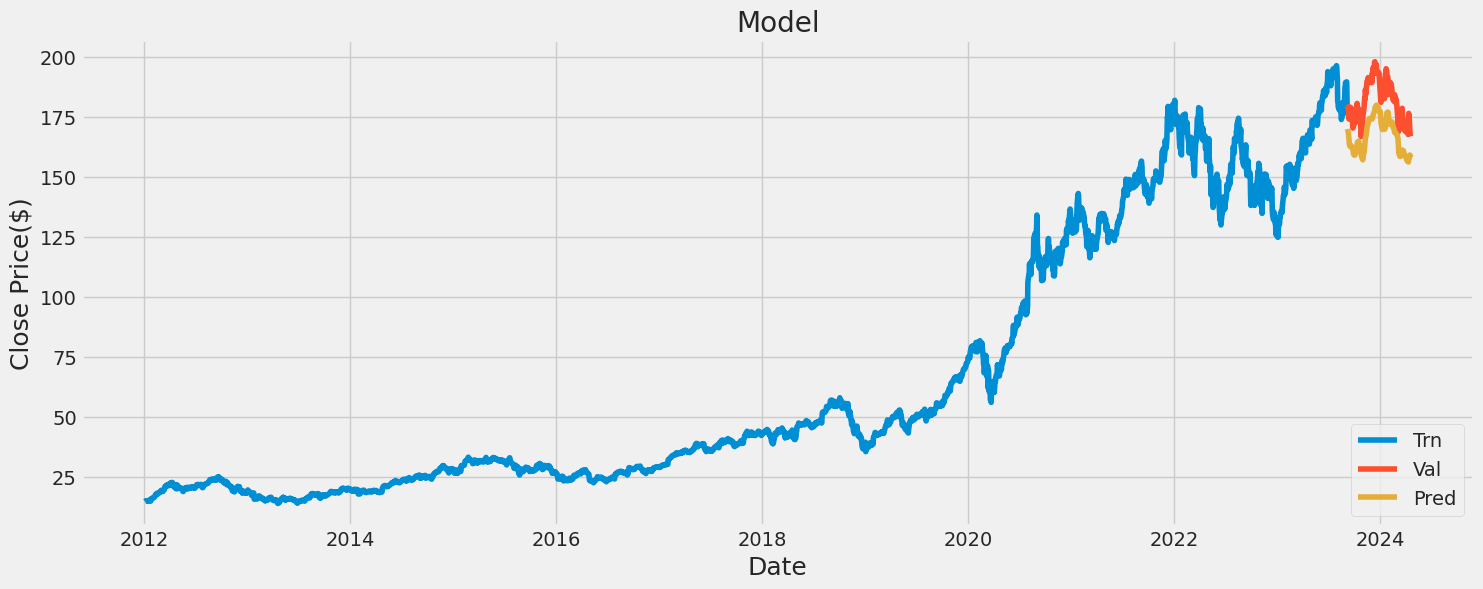

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Pred'] = predictions
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Pred']])
plt.legend(['Trn', 'Val', 'Pred'], loc='lower right')
plt.show()